In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df_master = pd.read_csv("data/CASP004-01/masterfile.csv")
df_master['product_brand'] = df_master['product_brand'].str.rstrip()
def correct_product_brand_spacing(df, column_name):
    # Add a space before the slash if it's not there and remove extra spaces after the slash
    df[column_name] = df[column_name].str.replace(r'/', ' / ').str.replace(r'\s+', ' ', regex=True)
    return df

df_master = correct_product_brand_spacing(df_master, 'product_brand')
df_master['material_I'] = df_master['material_I'].str.replace('Bioopolymer', 'Biopolymer')


In [62]:
df_end = df_master[df_master['trial_stage'] == 'End']
df_non_outlier = df_end[df_end['outlier_alert']==False]

def bar_whisker_plot(df, x, y, outlier):
    iqr = df.groupby(x)[y].apply(lambda g: g.quantile(0.75) - g.quantile(0.25))
    nonzero_iqr_order = df[df[x].isin(iqr[iqr > 0].index)].groupby(x)[y].median().sort_values(ascending=False).index
    zero_iqr_order = iqr[iqr == 0].index
    order = nonzero_iqr_order.append(zero_iqr_order)
    plt.figure(figsize=(12, 8))
    sns.boxplot(data = df, x=x, y=y, order=order)
    plt.title(f'{y} for Each {x} {outlier}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_violin(df, x, y):
    plt.figure(figsize=(8, 5))
    sns.violinplot(x=x, y=y, data=df, palette="viridis")
    plt.title('Violin Plot of % Residual for Each {x} Type')
    plt.xlabel(x)
    plt.ylabel(y)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

## Average Weight Pre and Post Composting

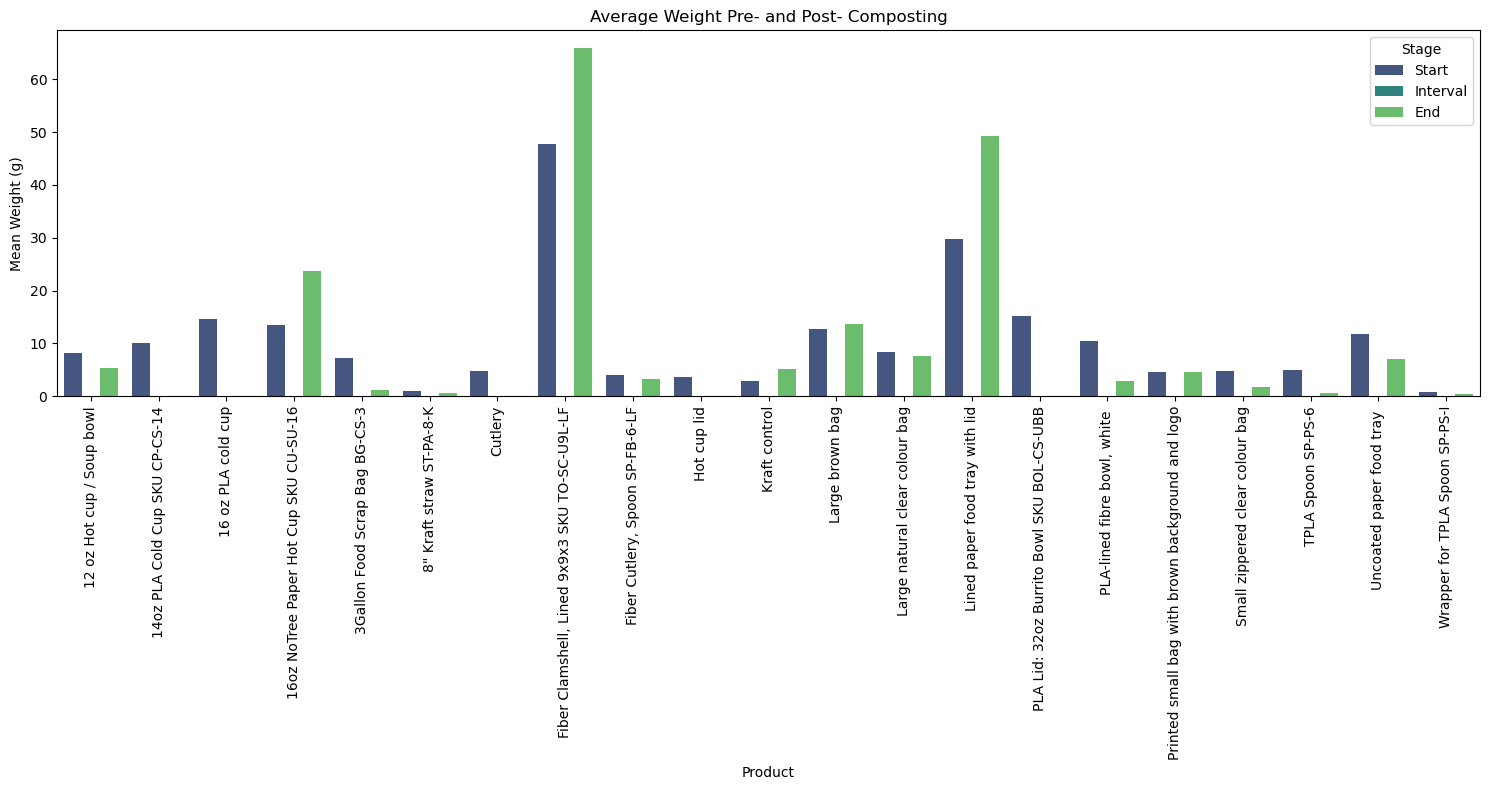

In [8]:
stage_order = pd.CategoricalDtype(
    categories=["Start", "Interval", "End"],
    ordered=True
)
df_master['trial_stage'] = df_master['trial_stage'].astype(stage_order)

stages_ordered = df_master.groupby(['product_name', 'trial_stage'])['mean_weight_final_g'].mean().reset_index().round(2)
plt.figure(figsize=(15, 8))
sns.barplot(x='product_name', y='mean_weight_final_g', hue='trial_stage', data=stages_ordered, palette="viridis")
plt.title('Average Weight Pre- and Post- Composting')
plt.xlabel('Product')
plt.ylabel('Mean Weight (g)')
plt.xticks(rotation=90)
plt.legend(title='Stage')
plt.tight_layout()
plt.show()

- As the CASP004-001 trial lacks data for the interval stage, the plot displays the average weight change of products by comparing the mean weight from start to the end of the trial. Notably, while some products completely decomposed, others, such as the 16oz No Tree Paper Hot Cup and the Fiber Clamshell, actually gained weight.

- Therefore, we tagged the products that add weight during decomposition as **anomalies**.

    For each observation, we check whether the final post-decomposition weight is smaller than the original manufacturing weight of the product tested. If this is not true, this product likely clumped with other products and represents an anomaly. We tagged it as an anomaly (column `outlier_alert`) so that we can perform anomaly specific analyses downstream. 

## % Residual by Products

- In this analysis, we have plotted the percentage of residuals by products for all data, as well as for data excluding anomalies. 

- Products are arranged on the x-axis according to their median values. 

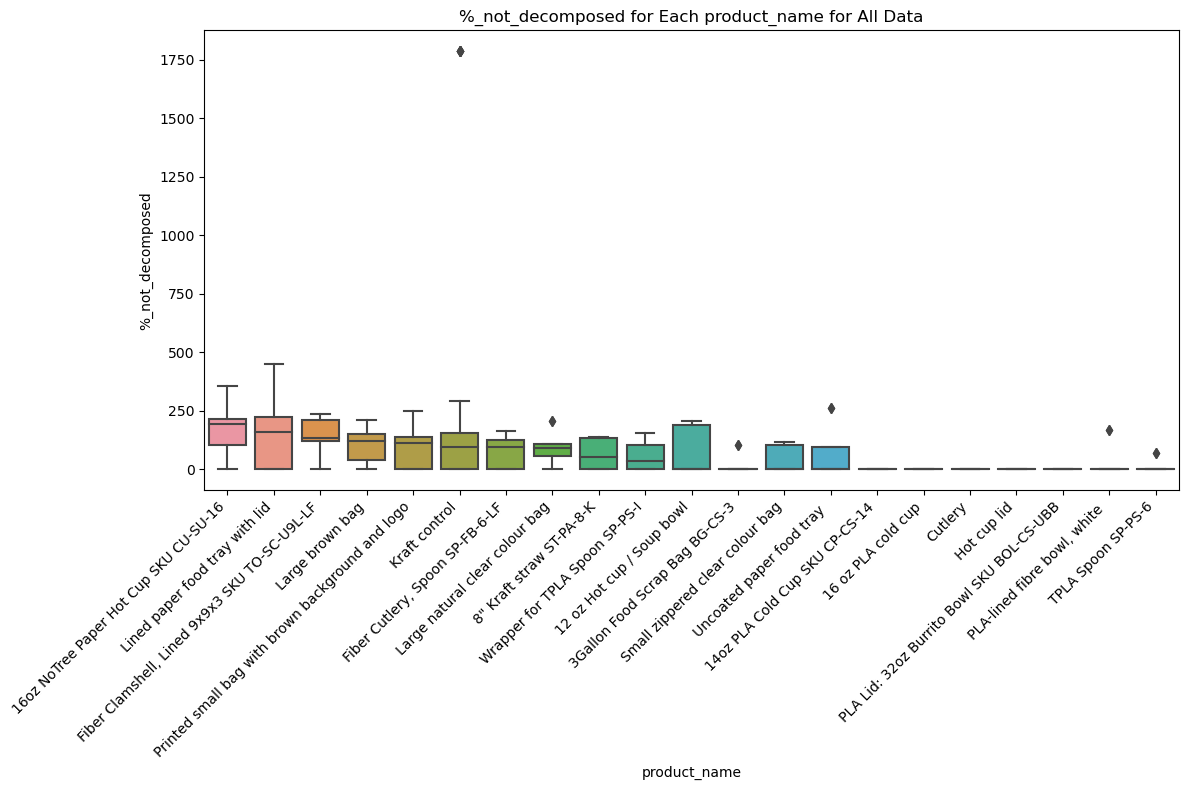

In [7]:
bar_whisker_plot(df_end, 'product_name', '%_not_decomposed', 'for All Data')

- From the first plot, it is evident that the 'kraft control' product shows an exceptionally high percentage of non-decomposition, specifically 1750%. This extreme value could potentially affect other aspects of the plot, i.e. scaling.

In [8]:
df_end.groupby('product_name')['%_not_decomposed'].median().sort_values(ascending=False)

product_name
16oz NoTree Paper Hot Cup SKU CU-SU-16              191.570
Lined paper food tray with lid                      159.730
Fiber Clamshell, Lined 9x9x3 SKU TO-SC-U9L-LF       130.910
Large brown bag                                     121.265
Printed small bag with brown background and logo    112.145
Kraft control                                        96.490
Fiber Cutlery, Spoon SP-FB-6-LF                      96.490
Large natural clear colour bag                       90.000
8" Kraft straw ST-PA-8-K                             52.335
Wrapper for TPLA Spoon SP-PS-I                       33.535
14oz PLA Cold Cup SKU CP-CS-14                        0.000
Hot cup lid                                           0.000
Cutlery                                               0.000
3Gallon Food Scrap Bag BG-CS-3                        0.000
PLA Lid: 32oz Burrito Bowl SKU BOL-CS-UBB             0.000
PLA-lined fibre bowl, white                           0.000
16 oz PLA cold cup         

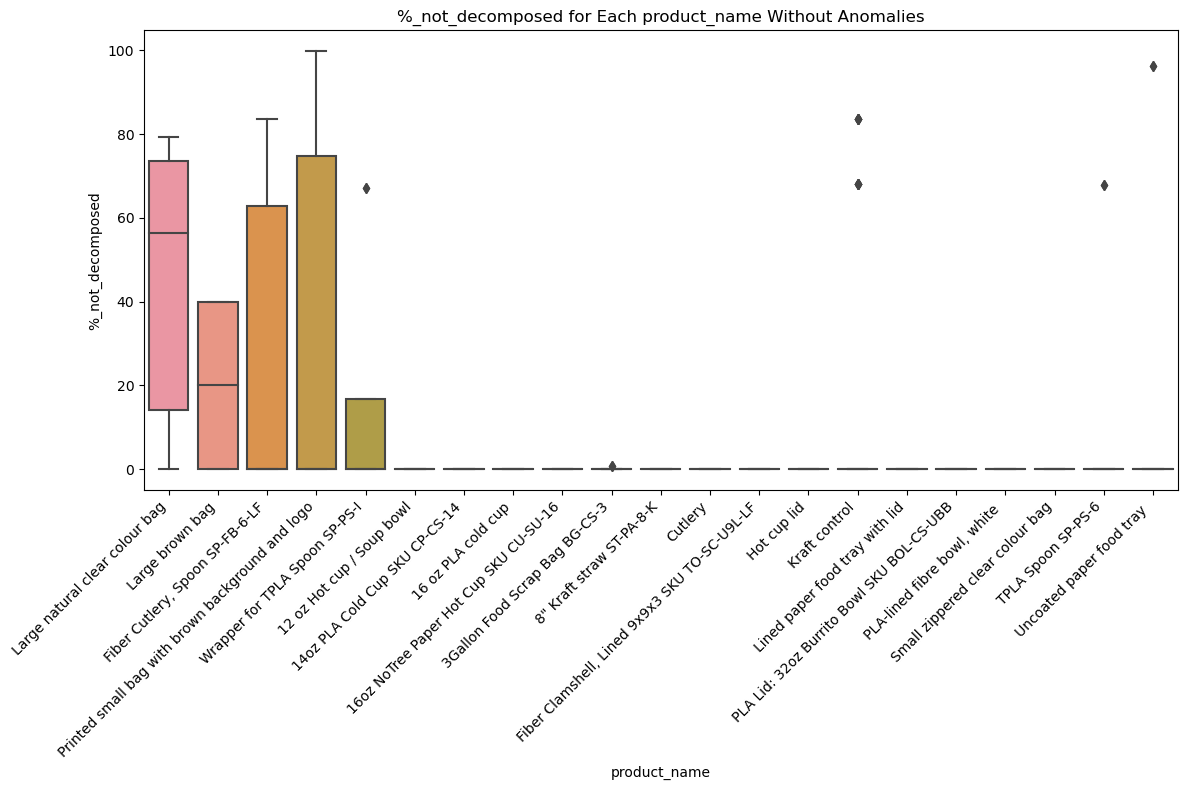

In [9]:
bar_whisker_plot(df_non_outlier, 'product_name', '%_not_decomposed', 'Without Anomalies')

- In the second plot, where all anomalies have been removed, we observe that the majority of the products have completely decomposed, indicated by their minimum, 25th percentile, median, and 75th percentile values all registering at 0. This results in them converging into a single line at 0.

## % Residual by Material Class I

- This analysis examines the effect of materials on decomposition, comparing overall data with anomaly-free data. 

- We used Material Class I for broader relevance, as Class III aligns too closely with product types. 

- Moreover, we annotated the outlier with their product name.

In [51]:
from adjustText import adjust_text

def bar_whisker_plot_annotate(df, x, y, outlier):
    df = df.dropna(subset=[x, y, 'product_name']) 

    # Calculate Interquartile Range (IQR) for each group
    iqr = df.groupby(x)[y].apply(lambda g: g.quantile(0.75) - g.quantile(0.25))
    
    # Determine the order of x-axis categories based on non-zero IQR
    nonzero_iqr_order = df[df[x].isin(iqr[iqr > 0].index)].groupby(x)[y].median().sort_values(ascending=False).index
    zero_iqr_order = iqr[iqr == 0].index
    order = nonzero_iqr_order.append(zero_iqr_order)
    
    # Create the boxplot
    plt.figure(figsize=(12, 8))
    sns.boxplot(data=df, x=x, y=y, order=order)
    
    # Calculate Q1, Q3 for identifying outliers
    Q1 = df.groupby(x)[y].apply(lambda g: g.quantile(0.25))
    Q3 = df.groupby(x)[y].apply(lambda g: g.quantile(0.75))
    IQR = Q3 - Q1
    threshold = 1.5  # Outlier threshold; adjust as needed

    # Identify outliers
    outliers = df.apply(lambda row: row[y] > Q3[row[x]] + threshold * IQR[row[x]] or
                                     row[y] < Q1[row[x]] - threshold * IQR[row[x]], axis=1)
    outlier_data = df[outliers]

    for index, row in outlier_data.iterrows():
        x_coord = order.tolist().index(row[x])

        # Dynamically adjust the y-offset
        y_offset = 10 if index % 2 == 0 else -20  # Alternate offset

        plt.annotate(row['product_name'],
                     xy=(x_coord, row[y]),
                     xytext=(0, y_offset),
                     textcoords='offset points',
                     ha='center',
                     va='bottom' if y_offset > 0 else 'top')

    # Set plot title and adjust x-ticks
    plt.title(f'{y} for Each {x} {outlier}')
    plt.xticks(rotation=45, ha='right')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()

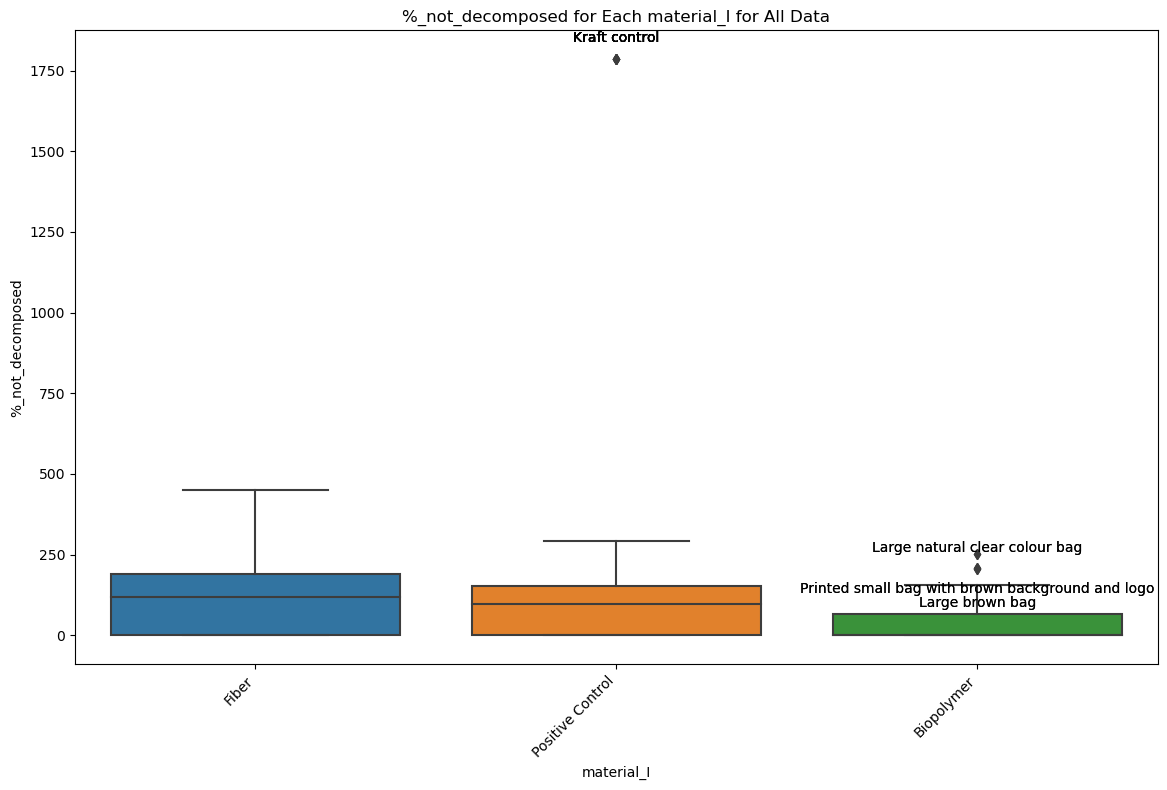

In [52]:
bar_whisker_plot_annotate(df_end, 'material_I', '%_not_decomposed', 'for All Data')

- The findings show fiber with the highest residuals, followed by positive control, and biopolymers with the least. 

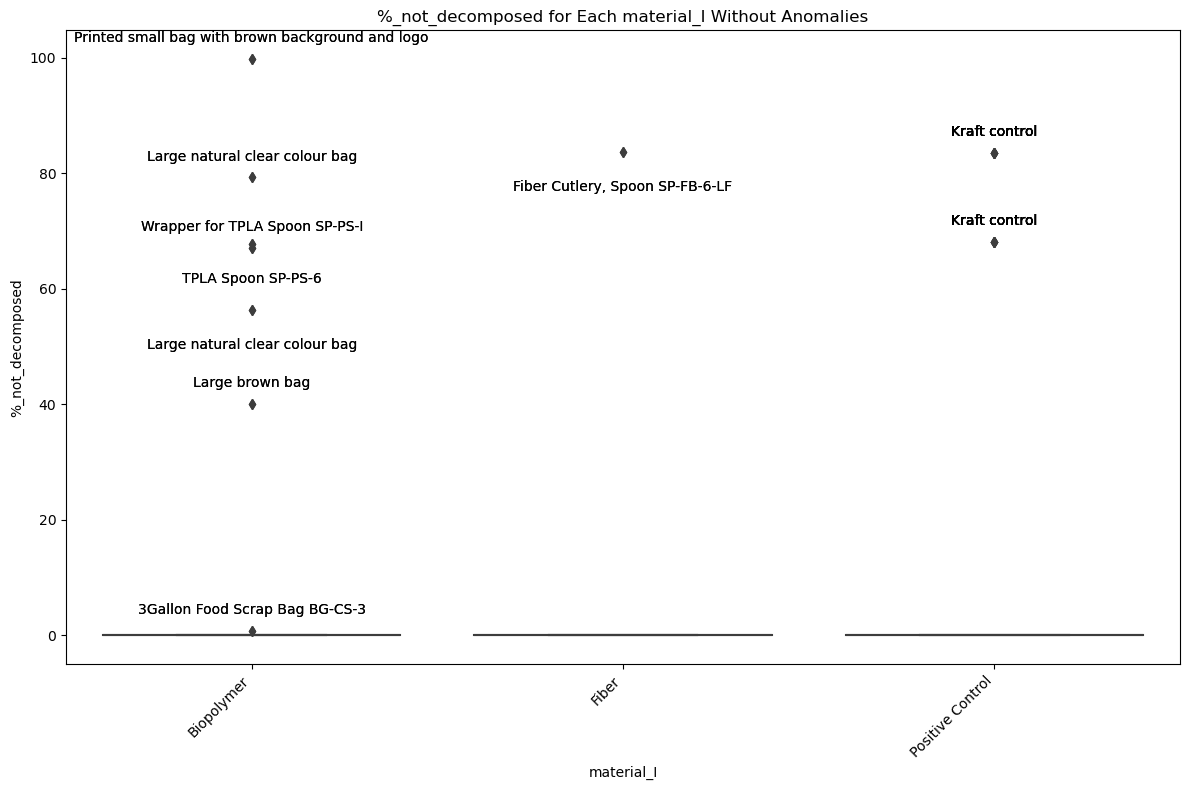

In [53]:
bar_whisker_plot_annotate(df_non_outlier, 'material_I', '%_not_decomposed', 'Without Anomalies')

- Without anomalies, all materials show zero residuals, but biopolymers exhibit more outliers than fiber. 

## Actual Distribution Plot by Material

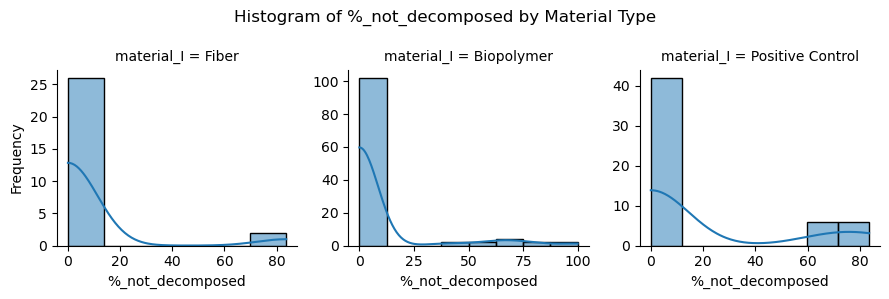

In [72]:
def plot_distribution(df, x, y):
    g = sns.FacetGrid(df, col=x, col_wrap=3, sharex=False, sharey=False) 
    g.map(sns.histplot, y, kde=True)  # KDE=True adds a density line

    g.fig.suptitle(f'Histogram of {y} by Material Type') 
    g.set_axis_labels(y, 'Frequency')

    g.tight_layout()
    plt.show()

plot_distribution(df_non_outlier, 'material_I', '%_not_decomposed')

## Violin Plots as Possible Format

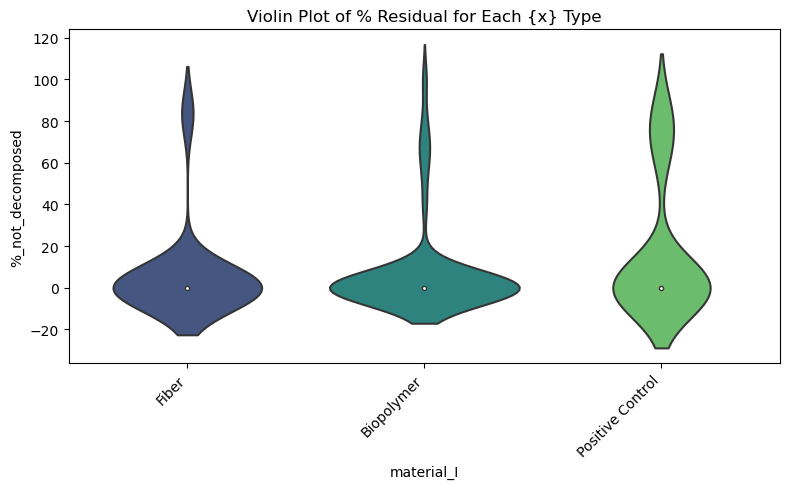

In [63]:
plot_violin(df_non_outlier, 'material_I', '%_not_decomposed')

## Actual distribution Plot by material

In [64]:
def plot_distribution(df, x, y):
    # Histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=y, kde=True)  # KDE=True adds a density line
    plt.title(f'Histogram of {y} for Each {x} Type')
    plt.xlabel(y)
    plt.ylabel('Frequency')
    plt.show()

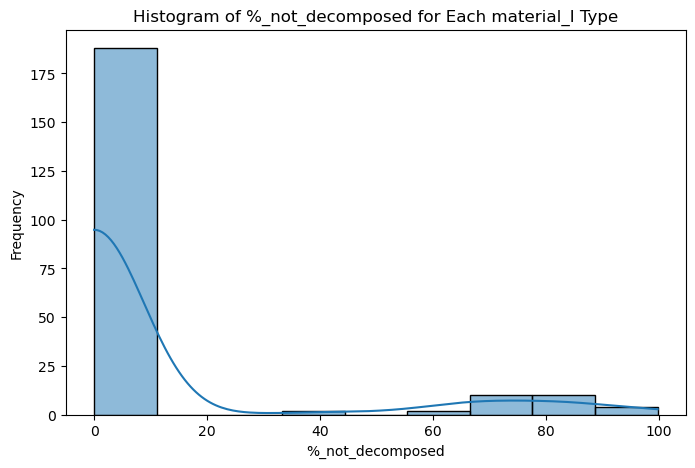

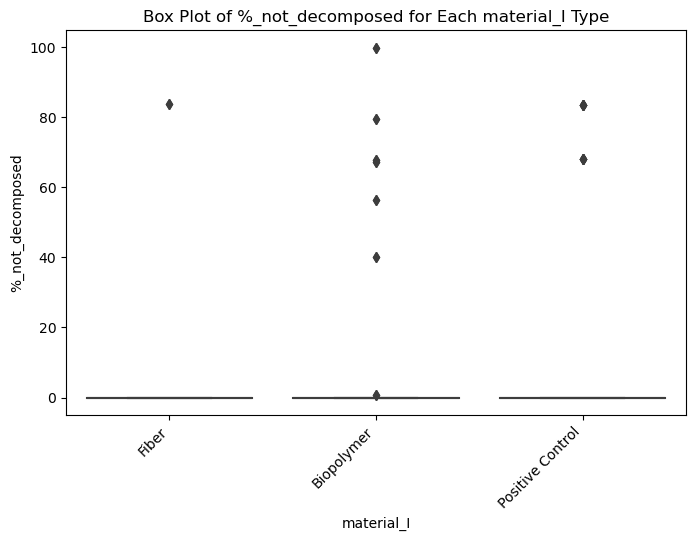

In [65]:
plot_distribution(df_non_outlier, 'material_I', '%_not_decomposed')